This is not the latest version, the latest version is in the hard drive. I will update it afterwards

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import keras 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform

2024-12-01 08:27:30.567078: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-01 08:27:30.594227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 08:27:30.594252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 08:27:30.594962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-01 08:27:30.599444: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set the environment variable to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
labels_df = pd.read_csv("/home/elahed/users/elahe/project with aws/all_steering_concat_plus_3000_plus_19000_plus_10000_normalized_4000.csv")
images_directory = '/home/elahed/users/elahe/project with aws/all_mix/'
labels = []
image_path = []
Image_and_label = []
# Iterate through the rows of the DataFrame
for index, row in labels_df.iterrows():
    labels.append([row['Steering']])
    image_path.append(os.path.join(images_directory, row['Image_Fname']+'.png'))  # Replace with the actual column name
    Image_and_label.append([os.path.join(images_directory, row['Image_Fname']+'.png'),row['Steering'],row['Throttle'],row['Brake']])

In [4]:
len(labels)

47312

In [5]:
print(labels)

[[-0.0001757331192493], [-0.0290558170527219], [-0.1157644242048263], [-0.2011808156967163], [-0.238523855805397], [-0.2518028318881988], [-0.3324058353900909], [-0.2487750351428985], [-0.167343869805336], [-0.0023876449558883], [0.0], [-0.0629938170313835], [-0.0634987875819206], [-0.0326580218970775], [-0.0685752630233764], [-0.0836720541119575], [-0.046024352312088], [-0.1219454854726791], [-0.0946602448821067], [-0.0856046751141548], [-0.0696641653776168], [-0.0862034857273101], [-0.0622783452272415], [-0.0284488014876842], [-0.0559873953461647], [-0.0418493002653121], [-0.0448765717446804], [-0.0551973357796669], [-0.1086793765425682], [-0.0587753430008888], [-0.0655750036239624], [-0.1178614124655723], [-0.0470511801540851], [-0.0145525112748146], [-0.0251891426742076], [-0.0871316045522689], [-0.0933011397719383], [-0.0363113097846508], [-0.0739417821168899], [-0.0522760711610317], [-0.10768523812294], [-0.0739441886544227], [-0.0685727298259735], [-0.0712684914469719], [-0.0345

In [6]:
print(labels[0])

[-0.0001757331192493]


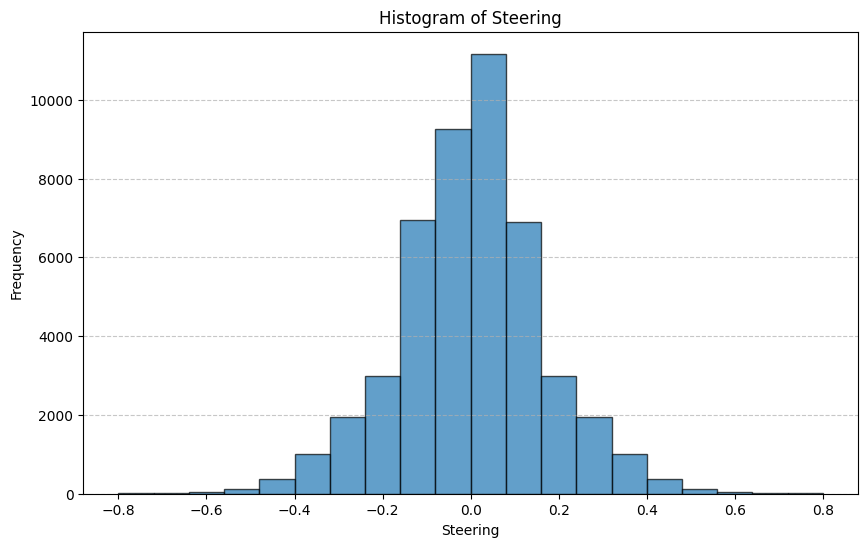

In [7]:
import matplotlib.pyplot as plt

# Plot the histogram for the 'Steering' column
column_name = 'Steering'

plt.figure(figsize=(10, 6))
plt.hist(labels_df[column_name], bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of {column_name}")
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [8]:
def flipping(img, steering):
    flip_image = cv2.flip(img,1)
    flip_steering = steering*-1.0
    return flip_image, flip_steering

def brightness(img,steering):
    bright_limit = (-0.5, 0.15)
    brightness_multiplier = 1.0 + np.random.uniform(low=bright_limit[0], high=bright_limit[1])
    image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image_hsv[:,:,2] = image_hsv[:,:,2] * brightness_multiplier
    bright_image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return bright_image , steering

In [ ]:
class My_Custom_Generator1(keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size, augment):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return (np.floor(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        inputs = []
        outputs = []

        for filename, labels in zip(batch_x, batch_y):
            try:
                # Load and preprocess the image
                img = cv2.imread(filename)
                if img is None:
                    raise ValueError(f"Cannot read image {filename}")

                img_resized = cv2.resize(img, (160, 160))
                inputs.append(img_resized)
                outputs.append(labels[0])

                # Apply augmentations if specified
                if self.augment[0] == 'Flip':
                    image, steer = flipping(img_resized, labels[0])
                    inputs.append(image)
                    outputs.append(steer)

                if self.augment[1] == 'bright':
                    image, steer = brightness(img_resized, labels[0])
                    inputs.append(image)
                    outputs.append(steer)

            except Exception as e:
                print(f"Skipping file {filename} due to error: {e}")

        # Convert to numpy arrays
        inputs_final = np.array(inputs).astype("float32") / 255.0
        outputs = np.array(outputs).astype("float32")
        return inputs_final, outputs


In [10]:
batch_size = 16
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(image_path,labels, test_size=0.1,shuffle=True)
train_generator = My_Custom_Generator1(X_train_data, y_train_data, batch_size,augment =["no","bright"] )
valid_generator = My_Custom_Generator1(X_valid_data, y_valid_data, batch_size,augment =["no","bright"] )

In [11]:
#### for test ####
'''
batch_size = 32
# Combine labels and class_labels for consistent splitting
train_generator = My_Custom_Generator1(image_path, labels, batch_size,augment =["no","bright"] )
'''

'\nbatch_size = 32\n# Combine labels and class_labels for consistent splitting\ntrain_generator = My_Custom_Generator1(image_path, labels, batch_size,augment =["no","bright"] )\n'

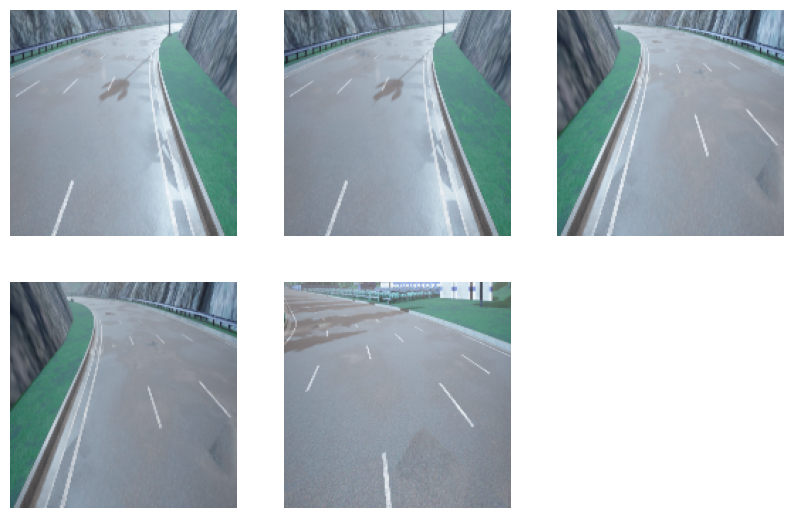

In [12]:
# Generate and plot 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    augmented_image = train_generator[0][0][i]
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.show()

In [13]:
len(X_train_data)

42580

In [14]:

def get_model():
    inputs_img = tf.keras.Input(shape=(160, 160, 3), name='input_image')

    # Conv block 1
    x = Conv2D(32, (5, 5), strides=2, padding='valid', name='conv1')(inputs_img)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu', name='relu1')(x)


    x = Conv2D(32, (3, 3), strides=1, padding='valid', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu', name='relu2')(x)

    # Conv block 2
    x = Conv2D(64, (3, 3), strides=2, padding='valid', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu', name='relu3')(x)

    x = Conv2D(64, (3, 3), strides=1, padding='valid', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu', name='relu4')(x)

    # Conv block 3
    x = Conv2D(128, (3, 3), strides=2, padding='valid', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu', name='relu5')(x)
    x = Dropout(rate=0.2, name='dropout5')(x)

    x = Conv2D(128, (3, 3), strides=1, padding='valid', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu', name='relu6')(x)

    # Conv block 4
    x = Conv2D(256, (3, 3), strides=1, padding='valid', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu', name='relu7')(x)

    x = Conv2D(256, (3, 3), strides=1, padding='valid', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu', name='relu8')(x)

    x = Flatten()(x)

    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2, name='dropout9')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(rate=0.2, name='dropout10')(x)
    x = Dense(256, activation='relu', name='fc3')(x)
    x = Dense(100, activation='relu', name='fc4')(x)
    x = Dense(50, activation='relu', name='fc5')(x)
    x = Dense(10, activation='relu', name='fc6')(x)

    output = Dense(1, name='fc7')(x)
    model_input = inputs_img
    model_output = output
    model = keras.Model(model_input, model_output)
    return model

IL_model = get_model()
IL_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 78, 78, 32)        2432      
                                                                 
 bn1 (BatchNormalization)    (None, 78, 78, 32)        128       
                                                                 
 relu1 (Activation)          (None, 78, 78, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 76, 76, 32)        9248      
                                                                 
 bn2 (BatchNormalization)    (None, 76, 76, 32)        128       
                                                                 
 relu2 (Activation)          (None, 76, 76, 32)        0     

2024-12-01 08:27:35.301909: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 08:27:35.326373: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-01 08:27:35.326550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

                                                                 
 relu6 (Activation)          (None, 15, 15, 128)       0         
                                                                 
 conv7 (Conv2D)              (None, 13, 13, 256)       295168    
                                                                 
 bn7 (BatchNormalization)    (None, 13, 13, 256)       1024      
                                                                 
 relu7 (Activation)          (None, 13, 13, 256)       0         
                                                                 
 conv8 (Conv2D)              (None, 11, 11, 256)       590080    
                                                                 
 bn8 (BatchNormalization)    (None, 11, 11, 256)       1024      
                                                                 
 relu8 (Activation)          (None, 11, 11, 256)       0         
                                                                 
 flatten (

In [15]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(IL_model, to_file='model.pdf', show_shapes=True, show_layer_names=True)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint directory and file format
#checkpoint_path = 'IL_model_22_all_plus_3000_retrain_turn_only_then_back_into_lane_ckpt.10-0.003.h5'
#IL_model.load_weights(checkpoint_path)

In [17]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.96)
optimizer_mine = keras.optimizers.Adam(learning_rate=lr_schedule)

2024-12-01 08:27:35.694803: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [18]:
# Specify the directory where TensorBoard logs will be stored
log_dir = "town06_all_bs64"

# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Checkpoint to save the best weights
model_ckpt_name = "IL_model_all_bs64"
checkpoint = ModelCheckpoint(model_ckpt_name + '_best.h5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Early stopping with restore_best_weights enabled
patience = 10
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=patience, 
                          verbose=1, 
                          mode='min', 
                          restore_best_weights=True)

# Combine all callbacks
callbacks = [checkpoint, earlystop, tensorboard_callback]

# Compile the model
IL_model.compile(optimizer=optimizer_mine, loss='MSE')

# Train the model
train_hist = IL_model.fit(train_generator,  
                          steps_per_epoch=len(X_train_data) // batch_size, 
                          epochs=500, 
                          validation_data=valid_generator,
                          validation_steps=len(X_valid_data) // batch_size,
                          shuffle=True,
                          verbose=1, 
                          callbacks=callbacks#,
                          #use_multiprocessing=True,
                          #workers=8
                          )


Epoch 1/500


2024-12-01 08:27:37.555036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-01 08:27:38.052546: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-01 08:27:38.097291: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-01 08:27:39.673390: I external/local_xla/xla/service/service.cc:168] XLA service 0x55f9ac35c620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-01 08:27:39.673413: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-01 08:27:39.676712: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer

 454/2661 [====>.........................] - ETA: 9:36 - loss: 0.1227

libpng error: IDAT: CRC error
2024-12-01 08:29:42.255239: W tensorflow/core/framework/op_kernel.cc:1827] UNKNOWN: error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Traceback (most recent call last):

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_genera

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Traceback (most recent call last):

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/tmp/ipykernel_2647979/914951532.py", line 22, in __getitem__
    inputs.append(cv2.resize(cv2.imread(filename) , (160,160)))

cv2.error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) UNKNOWN:  error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

Traceback (most recent call last):

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 270, in __call__
    ret = func(*args)

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/keras/src/engine/data_adapter.py", line 1064, in generator_fn
    yield x[i]

  File "/tmp/ipykernel_2647979/914951532.py", line 22, in __getitem__
    inputs.append(cv2.resize(cv2.imread(filename) , (160,160)))

cv2.error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_5168]

In [ ]:
IL_model.save('IL_town06_steer_bs_64.keras')
IL_model.save('IL_town06_steer_bs_64.h5')

#### Evaluation

In [ ]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('regression/IL_town06_steer_bs_32.h5')

# Confirm the model is loaded successfully
model.summary()


2024-11-22 15:00:33.677540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 15:00:33.677718: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-22 15:00:33.677792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 78, 78, 32)        2432      
                                                                 
 bn1 (BatchNormalization)    (None, 78, 78, 32)        128       
                                                                 
 relu1 (Activation)          (None, 78, 78, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 76, 76, 32)        9248      
                                                                 
 bn2 (BatchNormalization)    (None, 76, 76, 32)        128       
                                                                 
 relu2 (Activation)          (None, 76, 76, 32)        0     

In [ ]:
# Predict in batches
predicted_values = model.predict(train_generator, steps=len(image_path) // batch_size + 1, verbose=1)

2024-11-22 15:00:42.812206: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-22 15:00:42.855070: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1479/1479 [==============================] - 710s 479ms/step


In [ ]:
# Store predictions in the dataset
labels_df['predicted_steering']= predicted_values[:len(image_path)]

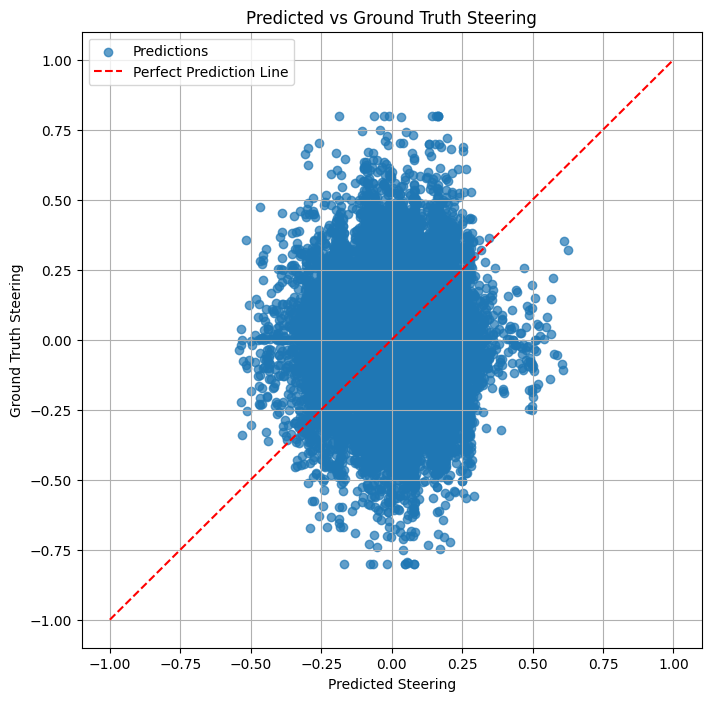

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


##### Scatter Plot: Predicted vs Ground Truth #####

ground_truth = labels_df['Steering']
predicted = labels_df['predicted_steering']   # Replace with your predicted data

plt.figure(figsize=(8, 8))
plt.scatter(predicted, ground_truth, alpha=0.7, label="Predictions")
plt.plot([-1, 1], [-1, 1], 'r--', label="Perfect Prediction Line")  # Diagonal line
plt.xlabel("Predicted Steering")
plt.ylabel("Ground Truth Steering")
plt.title("Predicted vs Ground Truth Steering")
plt.legend()
plt.grid()
plt.show()

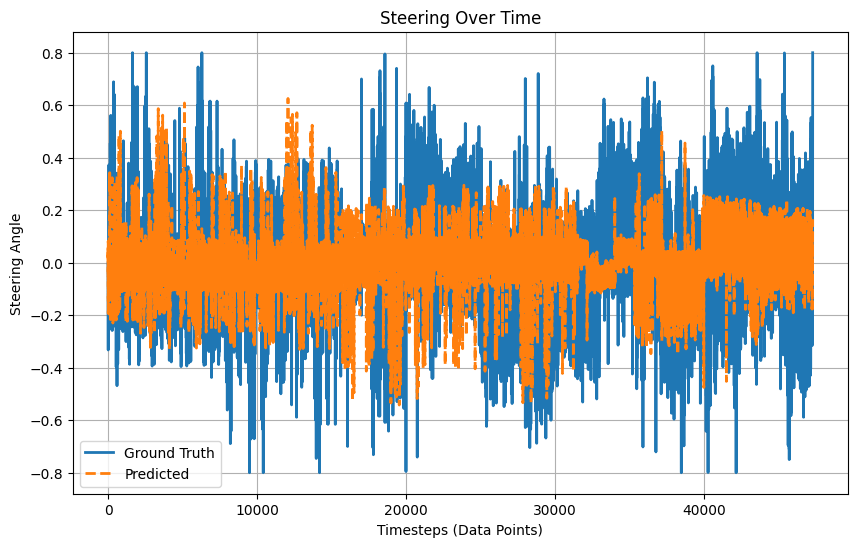

In [ ]:
##### Line Graph: Steering Over Time ######

timesteps = np.arange(len(ground_truth))  # Replace with your actual timesteps
plt.figure(figsize=(10, 6))
plt.plot(timesteps, ground_truth, label="Ground Truth", linewidth=2)
plt.plot(timesteps, predicted, label="Predicted", linestyle="dashed", linewidth=2)
plt.xlabel("Timesteps (Data Points)")
plt.ylabel("Steering Angle")
plt.title("Steering Over Time")
plt.legend()
plt.grid()
plt.show()